In [6]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from gensim.models import Word2Vec
import nltk

# Download necessary NLTK resources
nltk.download('punkt')

# Step 1: Read CSV file into DataFrame
file_path = '/teamspace/studios/this_studio/final.csv'  # Adjust path as needed
df = pd.read_csv(file_path)

# Check the first few rows of the DataFrame
print(df.head())

# Step 2: Tokenize the captions and prepare the training data

# Tokenizer setup
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['caption'])  # Fit the tokenizer on the 'caption' column
vocab_size = len(tokenizer.word_index) + 1  # Plus 1 for padding token

# Convert captions to sequences (list of integers)
X = tokenizer.texts_to_sequences(df['caption'])

# Pad the sequences to ensure equal length
max_length = max([len(seq) for seq in X])  # Or specify your own max length
X = pad_sequences(X, maxlen=max_length, padding='post')

# Step 3: Train the Word2Vec model
# Tokenize captions into words
tokenized_captions = [caption.split() for caption in df['caption']]

# Train Word2Vec model
w2v_model = Word2Vec(sentences=tokenized_captions, vector_size=100, window=5, min_count=1, workers=4)

# Step 4: Create the embedding matrix

# Initialize the embedding matrix with zeros (shape: vocab_size x embedding_dim)
embedding_dim = 100  # Word2Vec vector size
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# Loop through all words in the tokenizer's word index
for word, index in tokenizer.word_index.items():
    # If the word exists in the Word2Vec model's vocabulary, add its vector to the embedding matrix
    if word in w2v_model.wv:
        embedding_matrix[index] = w2v_model.wv[word]

# Check the embedding matrix
print(embedding_matrix.shape)  # Should print (vocab_size, embedding_dim)


[nltk_data] Downloading package punkt to
[nltk_data]     /teamspace/studios/this_studio/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


                                   video_name  \
0           .kady_297_7283115387103841544.mp4   
1           .sheeluvs_7223956928190369051.mp4   
2       12a6isthebest_7351604790822046983.mp4   
3  1life.anthonyblane_7348456410545540360.mp4   
4            414kenny_7033559034930384175.mp4   

                                             caption         category  
0  woman blue dress dancing crescent woman blue d...  Harmful Content  
1  person blue face black shirt girl black hair w...  Harmful Content  
2  two people sitting bench foot crossed two peop...  Harmful Content  
3  group people dancing room group men standing r...  Harmful Content  
4  person scoote skate person riding snowboard ra...  Harmful Content  
(2254, 100)


Epoch 1/10


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - accuracy: 0.6229 - loss: 0.8227 - val_accuracy: 0.8010 - val_loss: 0.5477
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - accuracy: 0.8180 - loss: 0.4792 - val_accuracy: 0.8163 - val_loss: 0.4615
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - accuracy: 0.8494 - loss: 0.3730 - val_accuracy: 0.8546 - val_loss: 0.3618
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - accuracy: 0.8874 - loss: 0.2977 - val_accuracy: 0.9107 - val_loss: 0.2651
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - accuracy: 0.8951 - loss: 0.2958 - val_accuracy: 0.8852 - val_loss: 0.2965
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - accuracy: 0.9017 - loss: 0.2658 - val_accuracy: 0.8801 - val_loss: 0.3903
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - accuracy: 0.9134 - loss: 0.2374 - val_accuracy: 0.9107 - val_loss: 0.2476
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - accuracy: 0.9088 - loss: 0.2345 - val_accuracy: 0.8954 - val_loss: 0

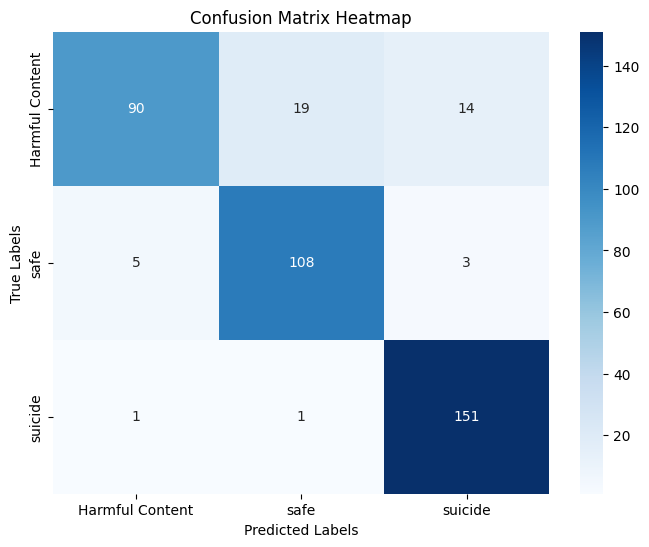

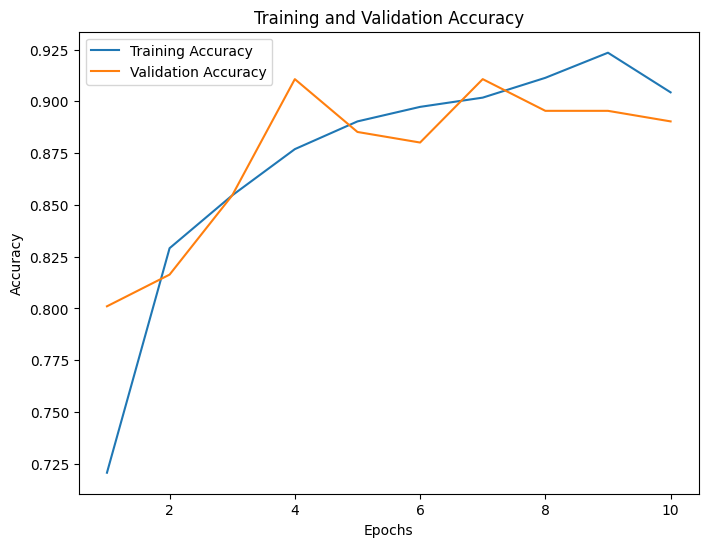

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Prepare labels
label_mapping = {label: idx for idx, label in enumerate(df['category'].unique())}
df['label'] = df['category'].map(label_mapping)

# Convert labels to one-hot encoding
y = to_categorical(df['label'], num_classes=len(label_mapping))

# Step 2: Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Build the Bidirectional LSTM model using the embedding matrix
model = Sequential([
    Embedding(input_dim=vocab_size,  # Size of vocabulary
              output_dim=embedding_dim,  # Dimension of Word2Vec vectors
              weights=[embedding_matrix],  # Pre-trained embedding matrix
              input_length=max_length,  # Length of padded sequences
              trainable=False),  # Keep embeddings fixed during training
    Bidirectional(LSTM(128, return_sequences=True)),  # First Bidirectional LSTM layer
    Dropout(0.3),  # Dropout for regularization
    Bidirectional(LSTM(128)),  # Second Bidirectional LSTM layer
    Dense(64, activation='relu'),  # Fully connected layer
    Dropout(0.3),  # Dropout
    Dense(len(label_mapping), activation='softmax')  # Output layer
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Step 4: Train the model and track accuracy
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

# Extract accuracy values from the history object
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

print(f"Final Training Accuracy: {train_accuracy[-1] * 100:.2f}%")
print(f"Final Validation Accuracy: {val_accuracy[-1] * 100:.2f}%")

# Step 6: Predictions for confusion matrix
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)  # Get class labels from probabilities
y_true = np.argmax(y_val, axis=1)  # True labels

# Step 7: Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Step 8: Plot confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Optionally: Plot accuracy curve for both training and validation
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

model.save('bidirectional_lstm_model_weights.h5')

Epoch 1/10


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.6180 - loss: 0.8484 - val_accuracy: 0.7347 - val_loss: 0.6135
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.7743 - loss: 0.5613 - val_accuracy: 0.7551 - val_loss: 0.6139
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.8271 - loss: 0.4732 - val_accuracy: 0.8546 - val_loss: 0.3909
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.8539 - loss: 0.3898 - val_accuracy: 0.8214 - val_loss: 0.4340
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.8741 - loss: 0.3595 - val_accuracy: 0.8750 - val_loss: 0.3333
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.8588 - loss: 0.3506 - val_accuracy: 0.8852 - val_loss: 0.2867
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.8721 - loss: 0.3295 - val_accuracy: 0.8852 - val_loss: 0.2932
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.8717 - loss: 0.3272 - val_accuracy: 0.8495 - val_loss: 0.

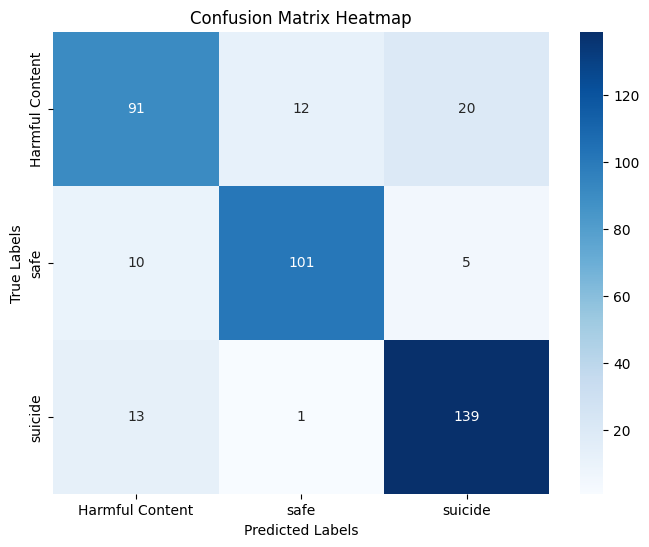

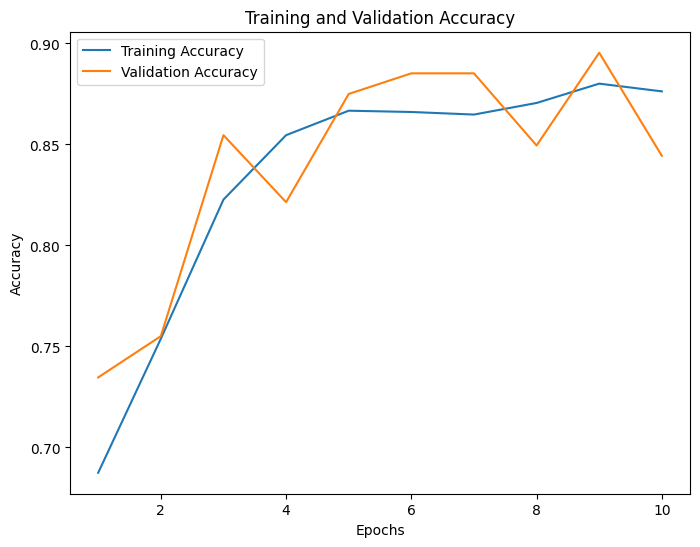

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
# Step 1: Prepare labels
label_mapping = {label: idx for idx, label in enumerate(df['category'].unique())}
df['label'] = df['category'].map(label_mapping)

# Convert labels to one-hot encoding
y = to_categorical(df['label'], num_classes=len(label_mapping))

# Step 2: Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Attention Mechanism Layer
class AttentionLayer(Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1]), initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(input_shape[-1],), initializer="zeros", trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        # Attention calculation: Q*K^T
        score = tf.matmul(inputs, self.W)
        score = tf.reduce_sum(score, axis=-1, keepdims=True) + self.b
        attention_weights = tf.nn.softmax(score, axis=1)
        context = attention_weights * inputs
        return tf.reduce_sum(context, axis=1)

# Step 4: Build the Bidirectional LSTM with Attention Layer
model = Sequential([
    # Embedding layer with your pre-trained Word2Vec embeddings
    Embedding(input_dim=vocab_size,  # Size of vocabulary
              output_dim=embedding_dim,  # Dimension of Word2Vec vectors
              weights=[embedding_matrix],  # Pre-trained embedding matrix
              input_length=max_length,  # Length of padded sequences
              trainable=False),  # Keep embeddings fixed during training
    
    # Bidirectional LSTM layer
    Bidirectional(LSTM(128, return_sequences=True)),  # Return sequences to feed into Attention
    Dropout(0.3),  # Dropout for regularization
    
    # Attention Layer
    AttentionLayer(),  # Custom Attention Layer

    # Dense output layer
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(label_mapping), activation='softmax')  # Output layer with softmax
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Step 4: Train the model and track accuracy
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

# Extract accuracy values from the history object
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

print(f"Final Training Accuracy: {train_accuracy[-1] * 100:.2f}%")
print(f"Final Validation Accuracy: {val_accuracy[-1] * 100:.2f}%")

# Step 6: Predictions for confusion matrix
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)  # Get class labels from probabilities
y_true = np.argmax(y_val, axis=1)  # True labels

# Step 7: Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Step 8: Plot confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Optionally: Plot accuracy curve for both training and validation
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

model.save('bidirectional_lstm_with_attention_model_weights.h5')

In [11]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 95.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 175.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 77.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 189.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 124.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 166.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 173.8 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.1
    Uninstalling tensorboard-2.15.1:
      Successfully uninstalled tensorboard-2.15.1
Note: you may need to restart the kernel to use updated packages.


In [ ]:
y

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [ ]:
df['label']

,label
0,0
1,0
2,0
3,0
4,0
...,...
1955,2
1956,2
1957,2
1958,2


In [ ]:
df.head(100)

,video_name,caption,category,label
0,.kady_297_7283115387103841544.mp4,woman blue dress dancing crescent woman blue d...,Harmful Content,0
1,.sheeluvs_7223956928190369051.mp4,person blue face black shirt girl black hair w...,Harmful Content,0
2,12a6isthebest_7351604790822046983.mp4,two people sitting bench foot crossed two peop...,Harmful Content,0
3,1life.anthonyblane_7348456410545540360.mp4,group people dancing room group men standing r...,Harmful Content,0
4,414kenny_7033559034930384175.mp4,person scoote skate person riding snowboard ra...,Harmful Content,0
...,...,...,...,...
95,chang0000_7341353566503767304.mp4,person wearing blue glove holding knife girl b...,Harmful Content,0
96,chaserost_6798221155900624134.mp4,man riding skateboard flight person skateboard...,Harmful Content,0
97,chideeetv_7137338406035557638.mp4,person holding box chip person holding box one...,Harmful Content,0
98,chimeracostumes_7337797148521663787.mp4,woman blue jacket cleaning pool man using hose...,Harmful Content,0


In [ ]:
# prompt: df save it to csv

df.to_csv('output.csv', index=False)

In [ ]:
df.shape

(1960, 4)